In [1]:
# Author: M. Riley Owens (GitHub: mrileyowens)

# This file computes LyC escape fractions 
# of the MagE spectra according to
# Rivera-Thorsen+19 (arXiv:1904.08186)

# To do: convolve the HST imaging to the seeing conditions of the
# ground-based MagE observations (FWHM ~ 0.7-0.9"). Convolve the 
# data with a 2D Gaussian kernel with sigma = FWHM / 2.35

In [2]:
import os
import glob

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.convolution import convolve_fft, Gaussian2DKernel

from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground, SExtractorBackground, ModeEstimatorBackground, MeanBackground, MMMBackground, BiweightLocationBackground

from reproject import reproject_interp

import stsynphot as STS

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

In [31]:
def measure():

    # Set up common directories
    home = os.getcwd()

    data = f'{home}/data'
    results = f'{home}/results'
    figs = f'{home}/figs'

    # Model Starburst99 spectrum
    sb99_file = f'{data}/spectra/plankarc_reddy_ext.txt'

    # File paths to masks of the arc and MagE apertures
    arc_mask_file = f'{results}/arc_mask_v5.fits'
    slitMaskFiles = [f'{results}/M5_mask_v5.fits',
        f'{results}/M4_mask_v5.fits',
        f'{results}/M6_mask_v5.fits',
        f'{results}/M3_mask_v5.fits',
        f'{results}/M0_mask_v5.fits',
        f'{results}/M2_mask_v5.fits',
        f'{results}/M7_mask_v5.fits',
        f'{results}/M8_mask_v5.fits',
        f'{results}/M9_mask_v5.fits'
    ]

    # The v5 reductions of the HST imaging in the F275W and F814W filters, with
    # an intervening galaxy removed by Alex with GALFIT, and cut to a smaller
    # footprint containing just the two largest arcs
    f275w_file = f'{data}/hst/galfit_cutouts/f275w_result_residual_v5_wcs.fits'
    f814w_file = f'{data}/hst/galfit_cutouts/f814w_result_residual_v5_wcs.fits'

    # Retrieve the data from the .fits files of the filters 
    f275w = fits.getdata(f275w_file)
    f814w = fits.getdata(f814w_file)

    # The GALFIT outputs are in units of total counts, so divide the data by the
    # total exposure time listed in the .fits header (which is the quantity)
    # Alex used to rescale the data into units of total counts. For the F275W
    # imaging, this does not seem to be the same quantity as the total 
    # exposure time that Mike listed in the HST observation log of the paper.
    # I don't know if this was a clerical error made by Mike when tabulating the
    # exposure times actually used, or if the exposure time in the header is
    # the incorrect source. Either way, I don't think it should make a difference
    # when computing the LyC escape fraction as long as I use the scaling factor
    # that Alex did.
    f275w = f275w / 87733
    f814w = f814w / 5280

    # Set sigma-clipping properties and background estimation method
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    bkg_estimator = MedianBackground()

    # Mask sources in the images
    f275w_source_mask = (f275w >= np.abs(np.median(f275w)))
    f814w_source_mask = (f814w >= 8 * np.abs(np.median(f814w)))
    
    # Create background models
    f275w_background = Background2D(f275w, (15, 15), filter_size=(3,3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,
        mask=f275w_source_mask, exclude_percentile=80.0, fill_value=0.0)
    f814w_background = Background2D(f814w, (20, 20), filter_size=(3,3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,
        mask=f814w_source_mask, exclude_percentile=20.0, fill_value=0.0)

    fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,10))

    ax[0].imshow(np.ma.masked_where(f275w_source_mask, f275w - f275w_background.background), origin='lower', cmap='viridis', vmin=-0.000001, vmax=0.000001)
    #ax[0].imshow(f275w_source_mask, origin='lower', cmap='Greens', alpha=0.5, vmin=0, vmax=1)
    ax[1].imshow(np.ma.masked_where(f814w_source_mask, f814w - f814w_background.background), origin='lower', cmap='viridis', vmin=-0.001, vmax=0.001)

    '''
    fig2, ax2 = plt.subplots(1,2, figsize=(20,10))

    ax2[0].hist((f275w - f275w_background.background)[f275w <= np.abs(np.median(f275w))], range=(-0.001,0.001), bins=20)#, range=(-2 * np.abs(np.median(f275w - f275w_background.background)), 2 * np.abs(np.median(f275w - f275w_background.background))))
    #ax2[1].hist(f814w, range=(-2500,2500), bins=10)#, range=(-2 * np.abs(np.median(f814w - f814w_background.background)), 2 * np.abs(np.median(f814w - f814w_background.background))))
    '''

    plt.show()

    # Open a data frame containing basic summary information about the MagE spectra
    df = pd.read_csv(f'{data}/spectra/mage/slits.txt', delimiter=' ', header=0)

    # Make arrays with the slit IDs and FWHMs of the time-averaged seeing conditions
    # of the MagE spectra
    slits = np.array(['M5', 'M4', 'M6', 'M3', 'M0', 'M2', 'M7', 'M8', 'M9'])
    fwhms = np.array([0.97, 0.71, 0.76, 0.70, 1.34, 0.77, 0.73, 0.7, 0.68])

    # Get an array of the base file names of the MagE spectra
    mageFilesBase = df.iloc[:,1].to_numpy(dtype=str)[2:]

    # Make an empty array that we will fill with the complete file paths
    # of the MagE spectra
    mageFiles = np.empty(np.shape(mageFilesBase), dtype=object)

    # Create array with full filepaths to MagE spectra
    for i, file in enumerate(mageFilesBase):
        file = f'{data}/spectra/mage/{file}'
        mageFiles[i] = file
    
    # Array containing redshifts of each slit
    z = df.iloc[:,2].to_numpy(dtype=np.float64)[2:]

    # Open Starburst99 model as a dataframe
    df = pd.read_csv(sb99_file, delimiter='\s+', header=None, engine='python')

    # Create wavelength, flux density, and flux density uncertainty arrays of 
    # the Starburst99 model
    w_sb99 = df.iloc[:,0].to_numpy()
    f_sb99 = df.iloc[:,1].to_numpy()
    ne_sb99 = df.iloc[:,2].to_numpy()

    # IGM transmission according to Rivera-Thorsen+19
    t_IGM = 0.69

    #arc_mask = fits.getdata(arc_mask_file)[3600:4700,3250:4450]

    # Reproject the mask of the arc to the footprint of the image cutouts, since the original arc mask
    # has a much larger footprint
    arc_mask, _ = reproject_interp(fits.open(arc_mask_file)[0], fits.getheader(f275w_file), hdu_in=0)

    # For good measure, make sure the arc mask is binary
    arc_mask = np.where(arc_mask > 0, 1, 0)

    # Reassign NaNs in the data as zeros
    f275w = np.where(np.isnan(f275w), 0.0, f275w)
    f814w = np.where(np.isnan(f814w), 0.0, f814w)

    # Convert background-subtracted HST imaging data from counts/s to erg/s/cm^2/Å
    f275w = (f275w - f275w_background.background) * fits.open(f'{data}/hst/V5.0_PSZ1G311.65-18.48_F275W_0.03g0.6_crsc1.2_0.7crsn3.5_3.0_drc_sci.fits')[0].header['PHOTFLAM']
    f814w = (f814w - f814w_background.background) * fits.open(f'{data}/hst/V5.0_PSZ1G311.65-18.48_F814W_0.03g0.6_crsc1.2_0.7crsn3.5_3.0_drc_sci.fits')[0].header['PHOTFLAM']

    # Retrieve transmission curve data for WFC3's F275W filter and ACS's F814W filter
    bp275 = STS.band('wfc3,uvis1,f275w,mjd#58216')
    bp814 = STS.band('acs,wfc1,f814w,mjd#58170')
    w275 = bp275.binset
    w814 = bp814.binset
    tpt275 = bp275(w275)
    tpt814 = bp814(w814)
    w275 = w275.value
    w814 = w814.value

    int1 = np.trapz(tpt275[(w275 >= 2100.0) & (w275 <= 3250.0)], x=w275[(w275 >= 2100.0) & (w275 <= 3250.0)])
    int2 = np.trapz(tpt814[(w814 >= 6500.0) & (w814 <= 10000.0)], x=w814[(w814 >= 6500.0) & (w814 <= 10000.0)])

    #kernel = Gaussian2DKernel(x_stddev=11.3475, y_stddev=11.3475)

    #f275 = convolve_fft(f275, kernel)
    #f814 = convolve_fft(f814, kernel)

    # For each slit
    for i, slit in enumerate(slits):
    
        # Compute the standard deviation from the Gaussian FWHM of the time-averaged seeing conditions, expressed in pixels (in this drizzling, 1 pixel is 0.03 arcseconds)
        stddev = (fwhms[i] / 2.355) / 0.03
    
        # Create a symmetric Gaussian kernel from the standard deviation
        kernel = Gaussian2DKernel(x_stddev=stddev, y_stddev=stddev)

        # Convolve the F275W and F814W images with the Gaussian kernel using the fast Fourier transform method. This saves significant time because of the size of the images
        f275w_convolved = convolve_fft(f275w, kernel)
        f814w_convolved = convolve_fft(f814w, kernel)
    
        # Convert .txt file with MagE data into a data frame
        df = pd.read_csv(mageFiles[i], delimiter='\t', header=0, skiprows=13)
    
        #Discard missing data
        df = df.apply(pd.to_numeric, errors='coerce').dropna()

        #Discard extreme outliers
        df = df[df.iloc[:,1] < 1e-20]

        #Reset the index
        df = df.reset_index(drop=True)

        # Extract wavelength, flux, and noise
        w = df.iloc[:,0].to_numpy()
        f = df.iloc[:,1].to_numpy() * 2.998e18 / np.square(w)
        ne = df.iloc[:,2].to_numpy() * 2.998e18 / np.square(w)
    
        # Place data into rest frame of the source
        w = w / (1.0 + z[i])
        f = f * (1.0 + z[i])
        ne = ne * (1.0 + z[i])
    
        # Interpolate MagE flux density at 1500 Å
        interpMage = interp1d(w, f)
        f1500Mage = interpMage(1500.0)
    
        # Interpolate S99 flux density at 1500 Å
        interpS99 = interp1d(w_sb99, f_sb99)
        f1500S99 = interpS99(1500.0)
    
        # Scale S99 to match MagE 1500 Å flux density
        f_sb99 = f_sb99 * (f1500Mage / f1500S99)
        ne_sb99 = ne_sb99 * (f1500Mage / f1500S99)
    
        w_sb99m = w_sb99 * (1.0 + z[i])
        f_sb99m = f_sb99 / (1.0 + z[i])
        ne_sb99m = ne_sb99 / (1.0 + z[i])
    
        w99m275 = w_sb99m[(w_sb99m >= 2100.0) & (w_sb99m <= 3250.0)]
        w99m814 = w_sb99m[(w_sb99m >= 6500.0) & (w_sb99m <= 10000.0)]
    
        f99m275 = f_sb99m[(w_sb99m >= 2100.0) & (w_sb99m <= 3250.0)]
        f99m814 = f_sb99m[(w_sb99m >= 6500.0) & (w_sb99m <= 10000.0)]
    
        ne99m275 = ne_sb99m[(w_sb99m >= 2100.0) & (w_sb99m <= 3250.0)]
        ne99m814 = ne_sb99m[(w_sb99m >= 6500.0) & (w_sb99m <= 10000.0)]
    
        interpT275 = interp1d(w275, tpt275)
        tpt275interp = interpT275(w99m275)
    
        interpT814 = interp1d(w814, tpt814)
        tpt814interp = interpT814(w99m814)
    
        int3 = np.trapz(tpt275interp * f99m275, x=w99m275)
        int4 = np.trapz(tpt814interp * f99m814, x=w99m814)
    
        areaArr = np.zeros(len(w99m275[:-1]))
        neAreaArr = np.zeros(len(w99m275[:-1]))
    
        for j, wav in enumerate(w99m275[:-1]):
        
            binSize = w99m275[j+1] - w99m275[j]
        
            area = binSize * (f99m275[j] + f99m275[j+1]) / 2.0
            neArea = (binSize / 2.0) * np.sqrt((ne99m275[j])**2 + (ne99m275[j+1])**2)
        
            areaArr[j] = area
            neAreaArr[j] = neArea
        
        neInt3 = np.sqrt(np.sum(neAreaArr ** 2))
    
        areaArr = np.zeros(len(w99m814[:-1]))
        neAreaArr = np.zeros(len(w99m814[:-1]))
    
        for j, wav in enumerate(w99m814[:-1]):
        
            binSize = w99m814[j+1] - w99m814[j]
        
            area = binSize * (f99m814[j] + f99m814[j+1]) / 2.0
            neArea = (binSize / 2.0) * np.sqrt((ne99m814[j])**2 + (ne99m814[j+1])**2)
        
            areaArr[j] = area
            neAreaArr[j] = neArea
        
        neInt4 = np.sqrt(np.sum(neAreaArr ** 2))
    
        #print(w99m[(w99m >= 2100.0) & (w99m <= 3250.0)])
        #print(w99m[(w99m >= 6500.0) & (w99m <= 10000.0)])
    
        #neInt3 = ( / 2.0) * np.sqrt()
    
        slitMask, _ = reproject_interp(fits.open(slitMaskFiles[i])[0], fits.getheader(f275w_file))
        slitMask = np.where(slitMask > 0, 1, 0)
    
        # Intersection between slit and arc masks
        intr = arc_mask * slitMask
    
        # Standard deviation of flux densities inside the mask but outside sources
    
        #ne275 = np.nanstd(np.where((slitMask * f275 == 0.0) | (f275 >= 0.0), np.nan, f275))
        #ne814 = np.nanstd(np.where((slitMask * f814 == 0.0) | (f814 / fits.open(f275file)[0].header['PHOTFLAM'] >= 0.001), np.nan, f814))
    
        #ne275 = np.nanstd(np.where((slitMask * f275w_convolved == 0.0) | (f275w_convolved >= 0.0), np.nan, f275w_convolved))
        #ne814 = np.nanstd(np.where((slitMask * f814w_convolved == 0.0) | (f814w_convolved / fits.open(f'{data}/hst/V5.0_PSZ1G311.65-18.48_F814W_0.03g0.6_crsc1.2_0.7crsn3.5_3.0_drc_sci.fits')[0].header['PHOTFLAM'] >= 0.001), np.nan, f814w_convolved))
        
        ne275 = np.nanstd(np.where((slitMask > 0) & (arc_mask < 1), f275w_convolved, np.nan))
        ne814 = np.nanstd(np.where((slitMask > 0) & (arc_mask < 1), f814w_convolved, np.nan))
    
        # Make error array where error is zero outside the slit and the standard deviation
        # computed above inside the slit
        ne275 = np.where(slitMask == 1.0, ne275, 0.0)
        ne814 = np.where(slitMask == 1.0, ne814, 0.0)
    
        # Total flux of the arc through the slit
        f275flux = np.sum(intr * f275w_convolved)
        f814flux = np.sum(intr * f814w_convolved)
    
        '''
        plt.imshow((intr * f275), cmap='RdBu', vmin=-0.0001 * 3.20590754285714e-18, 
                vmax=0.0001 * 3.20590754285714E-18, origin='lower')
        plt.colorbar()
        plt.show()
        '''
    
        ne275flux = np.sqrt(np.sum((intr * ne275) ** 2))
        ne814flux = np.sqrt(np.sum((intr * ne814) ** 2))
    
        esc = (f275flux * int1 * int4) / (t_IGM * f814flux * int2 * int3)
    
        neEsc = abs(esc) * np.sqrt((ne275flux / f275flux)**2 + (ne814flux / f814flux)**2 + (neInt3 / int3)**2 + (neInt4 / int4)**2)
    
        #neEsc = ((int1 * int4) / (tIGM * int2 * int3)) * abs(f814flux / f275flux) * np.sqrt((ne275flux / f275flux)**2 + (ne814flux / f814flux)**2)
    
        #print(neEsc)
    
        print(slit + ' |', 'F275W flux: ' + str(f275flux * 1e20) + ' +/- {}'.format(ne275flux * 1e20) + ',', 
            'F814W flux: ' + str(f814flux * 1e20) + ' +/- {}'.format(ne814flux * 1e20) + ',',
            'f_esc: ' + str(round(esc.value * 100.0, 3)) + ' +/- {}'.format(round(neEsc.value * 100.0, 3)))
        #print(esc.value * 100.0)

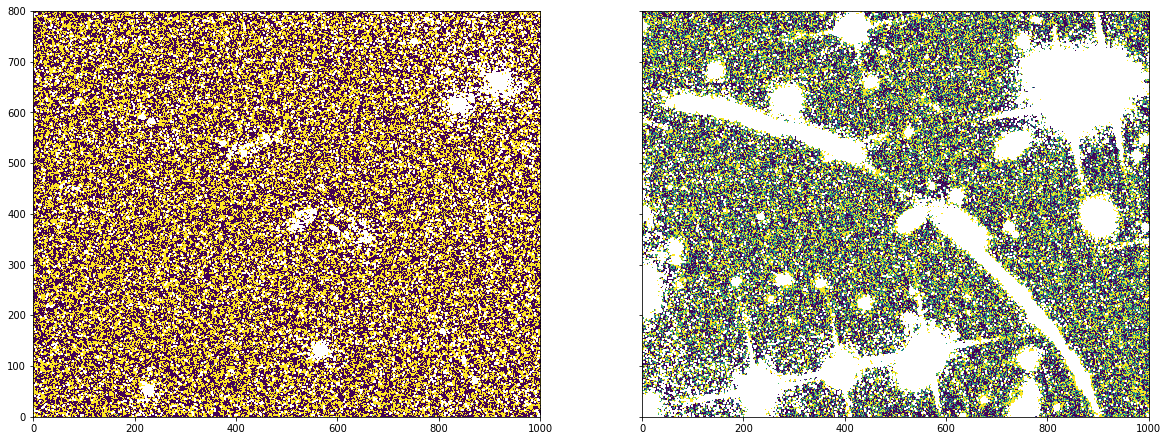

M5 | F275W flux: 4.147739167301043 +/- 0.10783703932175832, F814W flux: 214.8332792313487 +/- 1.3308722821974688, f_esc: 2.279 +/- 0.849
M4 | F275W flux: -1.761508409241556 +/- 0.12982966871018828, F814W flux: 374.9370723687398 +/- 0.4242753273868054, f_esc: -0.555 +/- 0.21
M6 | F275W flux: 10.147316381127723 +/- 0.1950139555599149, F814W flux: 379.7272595724719 +/- 0.7984656828630544, f_esc: 3.155 +/- 1.174
M3 | F275W flux: 7.502258636832033 +/- 0.23556241921557675, F814W flux: 392.99496432807706 +/- 0.6019562734129628, f_esc: 2.252 +/- 0.839
M0 | F275W flux: 70.35547181072346 +/- 0.14744498677636322, F814W flux: 492.2472588611608 +/- 0.7986179449501488, f_esc: 16.877 +/- 6.27
M2 | F275W flux: 89.03004071395895 +/- 0.24155814499057127, F814W flux: 594.2420681448699 +/- 1.2675621046361867, f_esc: 17.678 +/- 6.565
M7 | F275W flux: 31.085546550823224 +/- 0.18095314743261584, F814W flux: 297.9400159446616 +/- 0.18069844798047874, f_esc: 12.317 +/- 4.576
M8 | F275W flux: 23.639668925538718

In [32]:
measure()